In [7]:
# CELL 1: CÀI FONT + IMPORT
!apt-get update -qq && apt-get install -y fonts-noto-cjk -qq
!pip install transformers -q

import json
from dataclasses import dataclass
from pathlib import Path
from typing import List
import librosa
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import soundfile as sf
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset
from tqdm import tqdm
from transformers import Wav2Vec2Processor, Wav2Vec2Model

# --- Font Setup ---
try:
    from matplotlib import font_manager
    font_path = '/usr/share/fonts/truetype/noto/NotoSansCJK-Regular.ttc'
    font_manager.fontManager.addfont(font_path)
    plt.rcParams['font.family'] = 'Noto Sans CJK KR'
    print("Font: Noto Sans CJK KR loaded")
except:
    plt.rcParams.update({'font.family': 'DejaVu Sans', 'axes.unicode_minus': False})
    print("Font: Using fallback")

# --- Config ---
PROJECT_ROOT = Path(".").resolve()
DEFAULT_METADATA = Path("/kaggle/input/korean-single-speaker-speech-dataset/transcript.v.1.4.txt")
DEFAULT_AUDIO_ROOT = Path("/kaggle/input/korean-single-speaker-speech-dataset/kss")

PROCESSED_DIR = PROJECT_ROOT / "processed"
WAV_DIR = PROCESSED_DIR / "wav"
PHN_DIR = PROCESSED_DIR / "phoneme"
DICTIONARY_PATH = PROJECT_ROOT / "dictionary" / "ko_dict.txt"
MODEL_PATH = PROJECT_ROOT / "models" / "pronunciation_model.pt"

REPORT_DIR = PROJECT_ROOT / "reports"
for p in [PROCESSED_DIR, WAV_DIR, PHN_DIR, PROJECT_ROOT/"dictionary", PROJECT_ROOT/"models", REPORT_DIR]:
    p.mkdir(parents=True, exist_ok=True)

SAMPLE_RATE = 16000
# Wav2Vec2 configuration
WAV2VEC2_MODEL_NAME = "facebook/wav2vec2-base"  # hoặc "facebook/wav2vec2-large" nếu muốn dùng large model
WAV2VEC2_FEATURE_DIM = 768  # base model outputs 768-dim features

# --- Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using: {'GPU: ' + torch.cuda.get_device_name(0) if device.type=='cuda' else 'CPU'}")

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Font: Using fallback
Using: GPU: Tesla P100-PCIE-16GB


In [8]:
# CELL 2: KOREAN → IPA MAPPING + G2P
KOREAN_TO_IPA = {
    "ㄱ": "k",   "ㄲ": "kk",  "ㄴ": "n",   "ㄷ": "t",   "ㄸ": "tt",
    "ㄹ": "r/l", "ㅁ": "m",   "ㅂ": "p",   "ㅃ": "pp",  "ㅅ": "s",
    "ㅆ": "ss",  "ㅇ": "ŋ",   "ㅈ": "tɕ",  "ㅉ": "ttɕ", "ㅊ": "tɕʰ",
    "ㅋ": "kʰ",  "ㅌ": "tʰ",  "ㅍ": "pʰ",  "ㅎ": "h",
    "ㅏ": "a",   "ㅐ": "æ",   "ㅑ": "ja",  "ㅒ": "jæ",  "ㅓ": "ʌ",
    "ㅔ": "e",   "ㅕ": "jʌ",  "ㅖ": "je",  "ㅗ": "o",   "ㅘ": "wa",
    "ㅙ": "wæ",  "ㅚ": "ø",   "ㅛ": "jo",  "ㅜ": "u",   "ㅝ": "wʌ",
    "ㅞ": "we",  "ㅟ": "wi",  "ㅠ": "ju",  "ㅡ": "ɯ",   "ㅢ": "ɯi",
    "ㅣ": "i",
    "ㄳ": "ks",  "ㄵ": "ntɕ", "ㄶ": "nh",  "ㄺ": "lk",  "ㄻ": "lm",
    "ㄼ": "lp",  "ㄽ": "ls",  "ㄾ": "ltʰ", "ㄿ": "lpʰ", "ㅀ": "lh",
    "ㅄ": "ps",
    "<sp>": "<sp>", "<unk>": "<unk>"
}

LEADS = "ㄱㄲㄴㄷㄸㄹㅁㅂㅃㅅㅆㅇㅈㅉㅊㅋㅌㅍㅎ"
VOWELS = "ㅏㅐㅑㅒㅓㅔㅕㅖㅗㅘㅙㅚㅛㅜㅝㅞㅟㅠㅡㅢㅣ"
TAILS = ["", "ㄱ","ㄲ","ㄳ","ㄴ","ㄵ","ㄶ","ㄷ","ㄹ","ㄺ","ㄻ","ㄼ","ㄽ","ㄾ","ㄿ","ㅀ","ㅁ","ㅂ","ㅄ","ㅅ","ㅆ","ㅇ","ㅈ","ㅊ","ㅋ","ㅌ","ㅍ","ㅎ"]

def hangul_g2p(text: str) -> List[str]:
    """Chuyển chữ Hangul → danh sách phoneme (ㄱ, ㅏ, ㄴ, ...)"""
    phonemes = []
    for c in text.strip():
        code = ord(c)
        if 0xAC00 <= code <= 0xD7A3:  # Chữ cái Hangul
            s = code - 0xAC00
            l, v, t = s // 588, (s % 588) // 28, s % 28
            phonemes.append(LEADS[l])
            phonemes.append(VOWELS[v])
            if t: phonemes.append(TAILS[t])
        elif c == " ":
            phonemes.append("<sp>")
        else:
            phonemes.append(c)
    return phonemes

In [9]:
# CELL 3: CTC DATASET + COLLATE (TỐI ƯU) - WAV2VEC2
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F

# --- Initialize Wav2Vec2 Model (lazy loading) ---
_wav2vec2_model = None
_wav2vec2_processor = None
_wav2vec2_device = None

def get_wav2vec2_model():
    """Lazy load Wav2Vec2 model"""
    global _wav2vec2_model, _wav2vec2_processor, _wav2vec2_device
    if _wav2vec2_model is None:
        print(f"Loading Wav2Vec2 model: {WAV2VEC2_MODEL_NAME}")
        _wav2vec2_processor = Wav2Vec2Processor.from_pretrained(WAV2VEC2_MODEL_NAME)
        _wav2vec2_model = Wav2Vec2Model.from_pretrained(WAV2VEC2_MODEL_NAME)
        _wav2vec2_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        _wav2vec2_model.to(_wav2vec2_device)
        _wav2vec2_model.eval()
        print(f"✅ Wav2Vec2 loaded on {_wav2vec2_device}")
    return _wav2vec2_model, _wav2vec2_processor, _wav2vec2_device

# --- Wav2Vec2 Feature Extraction ---
def extract_features(audio, sr):
    """Extract features using Wav2Vec2 model"""
    model, processor, model_device = get_wav2vec2_model()
    
    # Ensure audio is numpy array
    if isinstance(audio, torch.Tensor):
        audio = audio.cpu().numpy()
    
    # Normalize audio
    if len(audio.shape) > 1:
        audio = audio.squeeze()
    
    # Ensure correct sample rate
    if sr != 16000:
        audio = librosa.resample(audio, orig_sr=sr, target_sr=16000)
    
    # Process audio
    inputs = processor(audio, sampling_rate=16000, return_tensors="pt", padding=True)
    
    # Move to model device
    inputs = {k: v.to(model_device) for k, v in inputs.items()}
    
    # Extract features (without gradients for efficiency)
    with torch.no_grad():
        outputs = model(**inputs)
        features = outputs.last_hidden_state  # (batch, seq_len, feature_dim)
    
    # Convert to numpy and return (remove batch dimension)
    features = features.squeeze(0).cpu().numpy()  # (T, 768)
    
    return features

# --- CTC Dataset with Feature Caching ---
@dataclass
class CTCSample:
    features: torch.Tensor      # (T, 768) - Wav2Vec2 features
    feat_len: int
    phoneme_ids: torch.Tensor  # (L,)
    phoneme_len: int

class CTCDataset(Dataset):
    def __init__(self, pairs, p2id, mean_std=None, feature_cache=None):
        """
        Args:
            pairs: List of (wav_path, phn_path) tuples
            p2id: Phoneme to ID mapping
            mean_std: (mean, std) tuple for normalization
            feature_cache: Optional dict mapping wav_path -> pre-extracted features
        """
        self.pairs = pairs
        self.p2id = p2id
        self.mean, self.std = mean_std or (0.0, 1.0)
        self.feature_cache = feature_cache or {}

    def __len__(self): return len(self.pairs)

    def __getitem__(self, i):
        wav_path, phn_path = self.pairs[i]
        
        # Check cache first
        if wav_path in self.feature_cache:
            feats = self.feature_cache[wav_path].copy()
        else:
            # Extract features if not in cache
            try:
                audio, sr = sf.read(wav_path)
                audio = librosa.resample(audio, orig_sr=sr, target_sr=SAMPLE_RATE)
            except:
                audio = np.zeros(SAMPLE_RATE, dtype=np.float32)
            
            feats = extract_features(audio, SAMPLE_RATE)
            # Cache for next time
            self.feature_cache[wav_path] = feats.copy()
        
        # Normalize
        feats = (feats - self.mean) / (self.std + 1e-8)
        feats = torch.tensor(feats, dtype=torch.float32)

        # Phonemes
        try:
            phonemes = phn_path.read_text(encoding="utf-8").split()
        except:
            phonemes = ["<unk>"]
        ids = torch.tensor([self.p2id.get(p, 0) for p in phonemes], dtype=torch.long)

        return CTCSample(
            features=feats,
            feat_len=feats.shape[0],
            phoneme_ids=ids,
            phoneme_len=len(ids)
        )

# --- Pre-extract Features Function ---
def pre_extract_features(pairs, batch_size=16, sample_n=None):
    """
    Pre-extract Wav2Vec2 features for all audio files
    This speeds up training significantly by avoiding re-extraction each epoch
    
    Args:
        pairs: List of (wav_path, phn_path) tuples
        batch_size: Batch size for feature extraction (larger = faster but more memory)
        sample_n: Optional limit on number of samples to process (for testing)
    
    Returns:
        Dictionary mapping wav_path -> features numpy array
    """
    print(f"\n{'='*70}")
    print("PRE-EXTRACTING WAV2VEC2 FEATURES")
    print(f"{'='*70}")
    print(f"Total samples: {len(pairs) if sample_n is None else sample_n}")
    print(f"Batch size: {batch_size}")
    print(f"This will speed up training significantly!")
    print(f"{'='*70}\n")
    
    # Load model
    model, processor, model_device = get_wav2vec2_model()
    
    feature_cache = {}
    pairs_to_process = pairs[:sample_n] if sample_n else pairs
    
    # Process in batches for efficiency
    for batch_start in tqdm(range(0, len(pairs_to_process), batch_size), desc="Extracting features"):
        batch_pairs = pairs_to_process[batch_start:batch_start + batch_size]
        batch_audios = []
        batch_paths = []
        
        # Load and resample audio
        for wav_path, _ in batch_pairs:
            try:
                audio, sr = sf.read(wav_path)
                audio = librosa.resample(audio, orig_sr=sr, target_sr=16000)
                batch_audios.append(audio)
                batch_paths.append(wav_path)
            except:
                continue
        
        if len(batch_audios) == 0:
            continue
        
        # Process batch
        with torch.no_grad():
            # Process all audios
            inputs = processor(batch_audios, sampling_rate=16000, return_tensors="pt", padding=True)
            inputs = {k: v.to(model_device) for k, v in inputs.items()}
            
            # Extract features
            outputs = model(**inputs)
            batch_features = outputs.last_hidden_state  # (batch, seq_len, 768)
            
            # Store in cache
            for i, wav_path in enumerate(batch_paths):
                features = batch_features[i].cpu().numpy()  # (seq_len, 768)
                feature_cache[wav_path] = features
    
    print(f"\n✅ Pre-extracted features for {len(feature_cache)} samples")
    return feature_cache

# --- CTC Collate ---
def ctc_collate_fn(batch):
    feats = [b.features for b in batch]
    feat_lens = torch.tensor([b.feat_len for b in batch], dtype=torch.long)
    ids = [b.phoneme_ids for b in batch]
    id_lens = torch.tensor([b.phoneme_len for b in batch], dtype=torch.long)

    feats = pad_sequence(feats, batch_first=True)
    ids = pad_sequence(ids, batch_first=True, padding_value=0)  # blank = 0

    return feats, feat_lens, ids, id_lens

In [ ]:
# ============================================================================
# CELL 4 MỚI - MODEL + TRAINING (FIXED COMPLETELY)
# ============================================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import CTCLoss
import numpy as np

# Import optuna (optional, chỉ dùng khi có trial)
try:
    import optuna
except ImportError:
    optuna = None

# --- Conformer Block (KHÔNG ĐỔI) ---
class ConformerBlock(nn.Module):
    def __init__(self, dim=512, heads=8, ff_mult=4, kernel_size=15, dropout=0.2):
        super().__init__()
        self.ff1 = nn.Linear(dim, dim * ff_mult)
        self.ff2 = nn.Linear(dim * ff_mult, dim)
        self.mhsa = nn.MultiheadAttention(dim, heads, batch_first=True, dropout=dropout)
        self.conv = nn.Sequential(
            nn.Conv1d(dim, dim*2, 1),
            nn.GLU(dim=1),
            nn.Conv1d(dim, dim, kernel_size, padding=kernel_size//2, groups=dim),
            nn.BatchNorm1d(dim),
            nn.GELU(),
            nn.Conv1d(dim, dim, 1),
            nn.Dropout(dropout)
        )
        self.ln1 = nn.LayerNorm(dim)
        self.ln2 = nn.LayerNorm(dim)
        self.ln3 = nn.LayerNorm(dim)
        self.ln_final = nn.LayerNorm(dim)
        self.dropout_rate = dropout

    def forward(self, x):
        residual = x
        x = self.ff1(x)
        x = F.gelu(x)
        x = self.ff2(x)
        x = F.dropout(x, self.dropout_rate, training=self.training)
        x = self.ln1(x + residual)

        residual = x
        x = self.mhsa(x, x, x)[0]
        x = self.ln2(x + residual)

        residual = x
        x = x.transpose(1, 2)
        x = self.conv(x)
        x = x.transpose(1, 2)
        x = self.ln3(x + residual)

        return self.ln_final(x)

# --- Model (UPDATED FOR WAV2VEC2) ---
class ConformerPronunciationModel(nn.Module):
    def __init__(self, input_dim=768, num_phonemes=55, dim=256, heads=4, depth=3, dropout=0.2):
        super().__init__()
        self.proj = nn.Linear(input_dim, dim)
        self.pos_emb = nn.Parameter(torch.zeros(1, 500, dim))
        self.blocks = nn.ModuleList([
            ConformerBlock(dim, heads, dropout=dropout)
            for _ in range(depth)
        ])
        self.fc = nn.Linear(dim, num_phonemes)
        self.dropout_rate = dropout

    def forward(self, x):
        x = self.proj(x)
        B, T, D = x.shape
        pos = self.pos_emb[:, :T, :]
        x = x + pos
        x = F.dropout(x, self.dropout_rate, training=self.training)
        for block in self.blocks:
            x = block(x)
        return self.fc(x)

# ============================================================================
# CRITICAL FIX 1: CTC GREEDY DECODE ĐÚNG
# ============================================================================
def ctc_greedy_decode(log_probs, blank_id=0):
    """
    CTC Greedy Decode ĐÚNG
    Input: (B, T, C) - log probabilities
    Output: List[List[int]] - decoded sequences
    """
    if log_probs.dim() == 2:
        log_probs = log_probs.unsqueeze(0)
    
    # Argmax theo dimension cuối
    preds = torch.argmax(log_probs, dim=-1)  # (B, T)
    
    batch_results = []
    for seq in preds:
        decoded = []
        prev = None  # ✅ FIX: Dùng None thay vì -1
        
        for token_id in seq.tolist():
            # Loại bỏ blank và duplicate liên tiếp
            if token_id != blank_id and token_id != prev:
                decoded.append(token_id)
            prev = token_id
        
        batch_results.append(decoded)
    
    return batch_results

# ============================================================================
# CRITICAL FIX 2: PHONEME ERROR RATE ĐÚNG
# ============================================================================
def compute_per(predictions, targets, target_lengths, blank_id=0):
    """
    Tính PER đúng: (S + D + I) / N
    S = Substitutions, D = Deletions, I = Insertions, N = Reference length
    """
    total_errors = 0
    total_length = 0
    
    for pred, target, target_len in zip(predictions, targets, target_lengths):
        # Lấy ground truth (loại bỏ padding và blank)
        target_seq = target[:target_len].tolist()
        target_seq = [t for t in target_seq if t != blank_id]
        
        # Predicted sequence (đã decode)
        pred_seq = pred
        
        if len(target_seq) == 0:
            continue
        
        # Tính Levenshtein distance
        n, m = len(pred_seq), len(target_seq)
        dp = [[0] * (m + 1) for _ in range(n + 1)]
        
        for i in range(n + 1):
            dp[i][0] = i
        for j in range(m + 1):
            dp[0][j] = j
        
        for i in range(1, n + 1):
            for j in range(1, m + 1):
                if pred_seq[i-1] == target_seq[j-1]:
                    dp[i][j] = dp[i-1][j-1]
                else:
                    dp[i][j] = min(
                        dp[i-1][j] + 1,      # deletion
                        dp[i][j-1] + 1,      # insertion
                        dp[i-1][j-1] + 1     # substitution
                    )
        
        edit_distance = dp[n][m]
        total_errors += edit_distance
        total_length += len(target_seq)
    
    per = total_errors / max(total_length, 1)
    return per

def levenshtein_distance(seq1, seq2):
    """
    Tính Levenshtein distance (edit distance) giữa 2 sequences
    Args:
        seq1, seq2: Lists of tokens
    Returns:
        Edit distance (int)
    """
    n, m = len(seq1), len(seq2)
    dp = [[0] * (m + 1) for _ in range(n + 1)]
    
    # Initialize
    for i in range(n + 1):
        dp[i][0] = i
    for j in range(m + 1):
        dp[0][j] = j
    
    # Fill DP table
    for i in range(1, n + 1):
        for j in range(1, m + 1):
            if seq1[i-1] == seq2[j-1]:
                dp[i][j] = dp[i-1][j-1]
            else:
                dp[i][j] = min(
                    dp[i-1][j] + 1,      # deletion
                    dp[i][j-1] + 1,      # insertion
                    dp[i-1][j-1] + 1     # substitution
                )
    
    return dp[n][m]

# ============================================================================
# CRITICAL FIX 3: TRAINING LOOP VỚI PER ĐÚNG + HỖ TRỢ OPTUNA TRIAL
# ============================================================================
def train_ctc(model, train_loader, val_loader, device, epochs=20, lr=1e-4, trial=None):
    """
    Training với PER tính ĐÚNG
    Args:
        model: Model to train
        train_loader: Training dataloader
        val_loader: Validation dataloader
        device: PyTorch device
        epochs: Number of epochs
        lr: Learning rate
        trial: Optional Optuna trial for hyperparameter optimization (HyperbandPruner)
    """
    criterion = CTCLoss(blank=0, zero_infinity=True)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=lr * 3,
        epochs=epochs,
        steps_per_epoch=len(train_loader),
        pct_start=0.1,
        anneal_strategy='cos'
    )

    hist = {
        "train_loss": [], "val_loss": [], 
        "train_per": [], "val_per": [], 
        "lr": []
    }
    
    best_val_per = float('inf')
    patience = 5
    patience_counter = 0

    print(f"\n{'='*70}")
    print(f"TRAINING STARTED - FULLY FIXED VERSION")
    if trial is not None:
        print(f"  🔍 OPTUNA TRIAL MODE (HyperbandPruner enabled)")
    print(f"{'='*70}")
    print(f"Learning Rate: {lr:.2e}")
    print(f"Epochs: {epochs}")
    print(f"Patience: {patience}")
    print(f"{'='*70}\n")

    for epoch in range(1, epochs + 1):
        # =====================================================================
        # TRAINING PHASE
        # =====================================================================
        model.train()
        train_losses = []
        all_train_preds = []
        all_train_targets = []
        all_train_lengths = []
        
        pbar = tqdm(train_loader, desc=f"Epoch {epoch:02d}/{epochs} [Train]")
        for batch_idx, (x, x_len, y, y_len) in enumerate(pbar):
            x, y = x.to(device), y.to(device)
            x_len, y_len = x_len.to(device), y_len.to(device)

            # Forward
            logits = model(x)
            log_probs = F.log_softmax(logits, dim=-1)
            log_probs_ctc = log_probs.transpose(0, 1).contiguous()
            loss = criterion(log_probs_ctc, y, x_len, y_len)

            # Backward
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

            train_losses.append(loss.item())

            # ✅ FIX: Decode predictions mỗi batch
            if batch_idx % 5 == 0:  # Mỗi 5 batches
                with torch.no_grad():
                    preds = ctc_greedy_decode(log_probs.cpu())
                    all_train_preds.extend(preds)
                    all_train_targets.extend(y.cpu())
                    all_train_lengths.extend(y_len.cpu())
            
            pbar.set_postfix({
                'loss': f'{loss.item():.3f}',
                'lr': f'{scheduler.get_last_lr()[0]:.2e}'
            })

        train_loss = np.mean(train_losses)
        
        # ✅ FIX: Tính PER đúng
        train_per = compute_per(
            all_train_preds, 
            all_train_targets, 
            all_train_lengths,
            blank_id=0
        )
        
        hist["train_loss"].append(train_loss)
        hist["train_per"].append(train_per)
        hist["lr"].append(scheduler.get_last_lr()[0])

        # =====================================================================
        # VALIDATION PHASE
        # =====================================================================
        model.eval()
        val_losses = []
        all_val_preds = []
        all_val_targets = []
        all_val_lengths = []
        
        with torch.no_grad():
            for x, x_len, y, y_len in tqdm(val_loader, desc=f"Epoch {epoch:02d}/{epochs} [Val]  "):
                x, y = x.to(device), y.to(device)
                x_len, y_len = x_len.to(device), y_len.to(device)
                
                logits = model(x)
                log_probs = F.log_softmax(logits, dim=-1)
                log_probs_ctc = log_probs.transpose(0, 1).contiguous()
                val_losses.append(criterion(log_probs_ctc, y, x_len, y_len).item())

                # Decode
                preds = ctc_greedy_decode(log_probs.cpu())
                all_val_preds.extend(preds)
                all_val_targets.extend(y.cpu())
                all_val_lengths.extend(y_len.cpu())

        val_loss = np.mean(val_losses)
        
        # ✅ FIX: Tính PER đúng
        val_per = compute_per(
            all_val_preds,
            all_val_targets,
            all_val_lengths,
            blank_id=0
        )
        
        hist["val_loss"].append(val_loss)
        hist["val_per"].append(val_per)

        # 🔍 OPTUNA: Report intermediate value cho HyperbandPruner
        if trial is not None:
            trial.report(val_per, epoch)
            # Check if should prune
            if trial.should_prune():
                print(f"\n✂️  TRIAL PRUNED at epoch {epoch} (Val PER: {val_per:.4f})")
                raise optuna.TrialPruned()

        # Print summary
        print(f"\n{'='*70}")
        print(f"Epoch {epoch:02d}/{epochs}:")
        print(f"  Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        print(f"  Train PER: {train_per:.4f} ({train_per*100:.1f}%) | Val PER: {val_per:.4f} ({val_per*100:.1f}%)")
        print(f"  LR: {hist['lr'][-1]:.2e}")

        # Save best model (chỉ khi không phải trial mode)
        if trial is None:
            if val_per < best_val_per:
                best_val_per = val_per
                torch.save(model.state_dict(), MODEL_PATH)
                print(f"  ✅ BEST MODEL SAVED! (Val PER: {val_per:.4f})")
                patience_counter = 0
            else:
                patience_counter += 1
                print(f"  ⚠️  No improvement ({patience_counter}/{patience})")
        else:
            # Trong trial mode, chỉ track best
            if val_per < best_val_per:
                best_val_per = val_per
        
        print(f"{'='*70}\n")

        # Early stopping (chỉ khi không phải trial mode)
        if trial is None and patience_counter >= patience:
            print(f"⛔ Early stopping at epoch {epoch}\n")
            break

        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    return hist if trial is None else best_val_per

# --- Evaluate PER ---
def evaluate_per(model, val_loader, device, id2p, blank_id=0):
    """Evaluate PER với hàm compute_per mới"""
    model.eval()
    all_preds = []
    all_targets = []
    all_lengths = []
    
    with torch.no_grad():
        for x, x_len, y, y_len in val_loader:
            x = x.to(device)
            logits = model(x)
            log_probs = F.log_softmax(logits, dim=-1)
            preds = ctc_greedy_decode(log_probs.cpu())
            
            all_preds.extend(preds)
            all_targets.extend(y)
            all_lengths.extend(y_len)
    
    per = compute_per(all_preds, all_targets, all_lengths, blank_id)
    return per

def clear_cache():
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

print("✅ FULLY FIXED Model + Training functions loaded!")

✅ FULLY FIXED Model + Training functions loaded!


In [11]:
# ============================================================================
# CELL 5 MỚI - FIX BLANK TOKEN + P2ID
# ============================================================================

import json
from pathlib import Path
from tqdm import tqdm
import numpy as np
import soundfile as sf
import librosa

# --- Cache paths ---
P2ID_CACHE = PROJECT_ROOT / "dictionary" / "p2id.json"
MEAN_STD_CACHE = PROJECT_ROOT / "dictionary" / "wav2vec2_stats.npy"

def prepare(metadata_p, audio_root, overwrite_wav=False, overwrite_phn=False):
    print("Running prepare...")
    
    # --- CRITICAL FIX: Tạo p2id với blank token ---
    if P2ID_CACHE.exists() and not (overwrite_wav or overwrite_phn):
        print(f"Loading phoneme dictionary from {P2ID_CACHE}")
        p2id = json.loads(P2ID_CACHE.read_text(encoding="utf-8"))
        id2p = {v: k for k, v in p2id.items()}
        print(f"Loaded {len(p2id)} phonemes")
    else:
        print("Creating phoneme dictionary WITH <blank> token...")
        phoneme_set = set()
        count = 0
        lines = metadata_p.read_text(encoding="utf-8").splitlines()
        
        for line in tqdm(lines[1:], desc="Scanning text"):
            parts = line.split("|")
            if len(parts) < 3: continue
            text = parts[2].strip()
            phns = hangul_g2p(text)
            phoneme_set.update(phns)
            count += 1
        
        # ✅ FIX: blank PHẢI là ID=0
        p2id = {"<blank>": 0}  # BLANK Ở ĐẦU!
        for i, p in enumerate(sorted(phoneme_set), start=1):
            p2id[p] = i
        
        id2p = {v: k for k, v in p2id.items()}
        P2ID_CACHE.write_text(json.dumps(p2id, ensure_ascii=False, indent=2))
        print(f"✅ Created dictionary: {len(p2id)} phonemes (including <blank>)")
        print(f"   <blank> → ID 0")
        print(f"   First 5: {list(p2id.items())[:5]}")

    # --- Resample WAV + Save .phn (KHÔNG ĐỔI) ---
    print("Processing audio files...")
    valid_pairs = []
    lines = metadata_p.read_text(encoding="utf-8").splitlines()
    
    for line in tqdm(lines[1:], desc="Audio"):
        parts = line.split("|")
        if len(parts) < 3: continue
        wav_name, text = parts[0].strip(), parts[2].strip()
        src_wav = audio_root / wav_name
        if not src_wav.exists():
            continue

        dst_wav = WAV_DIR / wav_name
        dst_wav.parent.mkdir(parents=True, exist_ok=True)
        dst_phn = PHN_DIR / wav_name.replace(".wav", ".phn")
        dst_phn.parent.mkdir(parents=True, exist_ok=True)

        try:
            if overwrite_wav or not dst_wav.exists():
                audio, sr = sf.read(src_wav)
                audio = librosa.resample(audio, orig_sr=sr, target_sr=SAMPLE_RATE)
                sf.write(dst_wav, audio, SAMPLE_RATE)
            
            if overwrite_phn or not dst_phn.exists():
                phns = hangul_g2p(text)
                dst_phn.write_text(" ".join(phns), encoding="utf-8")
            
            valid_pairs.append((dst_wav, dst_phn))
        except Exception as e:
            print(f"Failed {wav_name}: {e}")
            continue

    print(f"Prepared {len(valid_pairs)} valid samples")
    return p2id, id2p, valid_pairs

# --- Compute Wav2Vec2 Stats ---
def compute_wav2vec2_stats(pairs, sample_n=1000):
    """Compute mean and std for Wav2Vec2 features normalization"""
    if MEAN_STD_CACHE.exists():
        print(f"Loading Wav2Vec2 stats from {MEAN_STD_CACHE}")
        stats = np.load(MEAN_STD_CACHE)
        mean, std = stats[0], stats[1]
        print(f"Wav2Vec2 Mean: {mean:.6f}, Std: {std:.6f}")
        return mean, std

    print(f"Computing Wav2Vec2 stats from {min(sample_n, len(pairs))} samples...")
    print("⚠️  This may take a while as Wav2Vec2 feature extraction requires model inference...")
    
    # Initialize model
    get_wav2vec2_model()
    
    all_feats = []
    for wav_path, _ in tqdm(pairs[:sample_n], desc="Wav2Vec2 Stats"):
        try:
            audio, sr = sf.read(wav_path)
            audio = librosa.resample(audio, orig_sr=sr, target_sr=SAMPLE_RATE)
            feats = extract_features(audio, SAMPLE_RATE)
            all_feats.append(feats.flatten())
        except Exception as e:
            continue
    
    if len(all_feats) == 0:
        print("⚠️  No features extracted, using default stats")
        return 0.0, 1.0
    
    all_feats = np.concatenate(all_feats)
    mean, std = all_feats.mean(), all_feats.std()
    np.save(MEAN_STD_CACHE, np.array([mean, std]))
    print(f"Wav2Vec2 Mean: {mean:.6f}, Std: {std:.6f} → Saved")
    return mean, std

# =============================================================================
# CHẠY CHUẨN BỊ
# =============================================================================
p2id, id2p, valid_pairs = prepare(
    DEFAULT_METADATA, 
    DEFAULT_AUDIO_ROOT, 
    overwrite_wav=False,
    overwrite_phn=False
)

mean, std = compute_wav2vec2_stats(valid_pairs, sample_n=1000)

print(f"\n{'='*70}")
print(f"FINAL SUMMARY")
print(f"{'='*70}")
print(f"   Samples: {len(valid_pairs):,}")
print(f"   Phonemes: {len(p2id)} (including <blank>)")
print(f"   Feature dim: 768 (Wav2Vec2)")
print(f"   Normalization: Mean={mean:.6f}, Std={std:.6f}")
print(f"   ✅ <blank> token = ID 0")
print(f"{'='*70}")



Running prepare...
Loading phoneme dictionary from /kaggle/working/dictionary/p2id.json
Loaded 55 phonemes
Processing audio files...


Audio: 100%|██████████| 12853/12853 [00:23<00:00, 547.50it/s]

Prepared 12853 valid samples
Loading Wav2Vec2 stats from /kaggle/working/dictionary/wav2vec2_stats.npy
Wav2Vec2 Mean: -0.000540, Std: 0.308549

FINAL SUMMARY
   Samples: 12,853
   Phonemes: 55 (including <blank>)
   Feature dim: 768 (Wav2Vec2)
   Normalization: Mean=-0.000540, Std=0.308549
   ✅ <blank> token = ID 0



PREPARING DATASET
Pre-loading Wav2Vec2 model...
Loading Wav2Vec2 model: facebook/wav2vec2-base
✅ Wav2Vec2 loaded on cuda
✅ Wav2Vec2 model pre-loaded

OPTIMIZATION: Pre-extracting Wav2Vec2 features
This will take some time but will make training 10-20x faster!

PRE-EXTRACTING WAV2VEC2 FEATURES
Total samples: 12853
Batch size: 32
This will speed up training significantly!



Extracting features: 100%|██████████| 402/402 [03:32<00:00,  1.89it/s]



✅ Pre-extracted features for 12853 samples
✅ Cached features for 12853 samples
Train samples: 11,567
Val samples: 1,286

MODEL ARCHITECTURE (OPTIMIZED)
Parameters: 3,317,303
Hidden Dim: 256 (reduced from 384)
Depth: 3 (reduced from 4)
Heads: 4 (reduced from 6)
Dropout: 0.2
Batch Size: 24

🚀 Starting training with FIXED PER calculation...


TRAINING STARTED - FULLY FIXED VERSION
Learning Rate: 1.00e-04
Epochs: 25
Patience: 5



Epoch 01/25 [Val]  : 100%|██████████| 54/54 [00:02<00:00, 18.49it/s]



Epoch 01/25:
  Train Loss: 4.0926 | Val Loss: 1.7181
  Train PER: 1.2762 (127.6%) | Val PER: 0.4963 (49.6%)
  LR: 1.12e-04
  ✅ BEST MODEL SAVED! (Val PER: 0.4963)



Epoch 02/25 [Val]  : 100%|██████████| 54/54 [00:02<00:00, 18.36it/s]



Epoch 02/25:
  Train Loss: 1.2016 | Val Loss: 0.8412
  Train PER: 0.8554 (85.5%) | Val PER: 0.2485 (24.9%)
  LR: 2.73e-04
  ✅ BEST MODEL SAVED! (Val PER: 0.2485)



Epoch 03/25 [Val]  : 100%|██████████| 54/54 [00:02<00:00, 18.43it/s]



Epoch 03/25:
  Train Loss: 0.7253 | Val Loss: 0.5734
  Train PER: 0.2429 (24.3%) | Val PER: 0.1996 (20.0%)
  LR: 3.00e-04
  ✅ BEST MODEL SAVED! (Val PER: 0.1996)



Epoch 04/25 [Val]  : 100%|██████████| 54/54 [00:02<00:00, 18.55it/s]



Epoch 04/25:
  Train Loss: 0.5464 | Val Loss: 0.4864
  Train PER: 0.1924 (19.2%) | Val PER: 0.1699 (17.0%)
  LR: 2.97e-04
  ✅ BEST MODEL SAVED! (Val PER: 0.1699)



Epoch 05/25 [Val]  : 100%|██████████| 54/54 [00:02<00:00, 18.29it/s]



Epoch 05/25:
  Train Loss: 0.4621 | Val Loss: 0.4096
  Train PER: 0.1659 (16.6%) | Val PER: 0.1398 (14.0%)
  LR: 2.91e-04
  ✅ BEST MODEL SAVED! (Val PER: 0.1398)



Epoch 06/25 [Val]  : 100%|██████████| 54/54 [00:02<00:00, 18.41it/s]



Epoch 06/25:
  Train Loss: 0.4036 | Val Loss: 0.3758
  Train PER: 0.1427 (14.3%) | Val PER: 0.1396 (14.0%)
  LR: 2.82e-04
  ✅ BEST MODEL SAVED! (Val PER: 0.1396)



Epoch 07/25 [Val]  : 100%|██████████| 54/54 [00:02<00:00, 18.33it/s]



Epoch 07/25:
  Train Loss: 0.3575 | Val Loss: 0.3596
  Train PER: 0.1299 (13.0%) | Val PER: 0.1219 (12.2%)
  LR: 2.71e-04
  ✅ BEST MODEL SAVED! (Val PER: 0.1219)



Epoch 08/25 [Val]  : 100%|██████████| 54/54 [00:02<00:00, 18.56it/s]



Epoch 08/25:
  Train Loss: 0.3248 | Val Loss: 0.3393
  Train PER: 0.1185 (11.8%) | Val PER: 0.1114 (11.1%)
  LR: 2.58e-04
  ✅ BEST MODEL SAVED! (Val PER: 0.1114)



Epoch 09/25 [Val]  : 100%|██████████| 54/54 [00:02<00:00, 18.48it/s]



Epoch 09/25:
  Train Loss: 0.2980 | Val Loss: 0.3237
  Train PER: 0.1137 (11.4%) | Val PER: 0.1145 (11.4%)
  LR: 2.42e-04
  ⚠️  No improvement (1/5)



Epoch 10/25 [Val]  : 100%|██████████| 54/54 [00:02<00:00, 18.48it/s]



Epoch 10/25:
  Train Loss: 0.2716 | Val Loss: 0.3087
  Train PER: 0.1135 (11.4%) | Val PER: 0.1156 (11.6%)
  LR: 2.25e-04
  ⚠️  No improvement (2/5)



Epoch 11/25 [Val]  : 100%|██████████| 54/54 [00:02<00:00, 18.35it/s]



Epoch 11/25:
  Train Loss: 0.2456 | Val Loss: 0.2988
  Train PER: 0.1043 (10.4%) | Val PER: 0.1154 (11.5%)
  LR: 2.06e-04
  ⚠️  No improvement (3/5)



Epoch 12/25 [Val]  : 100%|██████████| 54/54 [00:02<00:00, 18.48it/s]



Epoch 12/25:
  Train Loss: 0.2228 | Val Loss: 0.2860
  Train PER: 0.0950 (9.5%) | Val PER: 0.1093 (10.9%)
  LR: 1.86e-04
  ✅ BEST MODEL SAVED! (Val PER: 0.1093)



Epoch 13/25 [Val]  : 100%|██████████| 54/54 [00:02<00:00, 18.59it/s]



Epoch 13/25:
  Train Loss: 0.2039 | Val Loss: 0.2910
  Train PER: 0.0965 (9.7%) | Val PER: 0.1111 (11.1%)
  LR: 1.66e-04
  ⚠️  No improvement (1/5)



Epoch 14/25 [Val]  : 100%|██████████| 54/54 [00:02<00:00, 18.58it/s]



Epoch 14/25:
  Train Loss: 0.1841 | Val Loss: 0.2834
  Train PER: 0.0886 (8.9%) | Val PER: 0.1000 (10.0%)
  LR: 1.45e-04
  ✅ BEST MODEL SAVED! (Val PER: 0.1000)



Epoch 15/25 [Val]  : 100%|██████████| 54/54 [00:02<00:00, 18.37it/s]



Epoch 15/25:
  Train Loss: 0.1679 | Val Loss: 0.2772
  Train PER: 0.0824 (8.2%) | Val PER: 0.1013 (10.1%)
  LR: 1.24e-04
  ⚠️  No improvement (1/5)



Epoch 16/25 [Val]  : 100%|██████████| 54/54 [00:02<00:00, 18.48it/s]



Epoch 16/25:
  Train Loss: 0.1531 | Val Loss: 0.2713
  Train PER: 0.0829 (8.3%) | Val PER: 0.1006 (10.1%)
  LR: 1.04e-04
  ⚠️  No improvement (2/5)



Epoch 17/25 [Val]  : 100%|██████████| 54/54 [00:02<00:00, 18.36it/s]



Epoch 17/25:
  Train Loss: 0.1391 | Val Loss: 0.2731
  Train PER: 0.0779 (7.8%) | Val PER: 0.1023 (10.2%)
  LR: 8.42e-05
  ⚠️  No improvement (3/5)



Epoch 18/25 [Val]  : 100%|██████████| 54/54 [00:02<00:00, 18.36it/s]



Epoch 18/25:
  Train Loss: 0.1265 | Val Loss: 0.2706
  Train PER: 0.0688 (6.9%) | Val PER: 0.0967 (9.7%)
  LR: 6.61e-05
  ✅ BEST MODEL SAVED! (Val PER: 0.0967)



Epoch 19/25 [Val]  : 100%|██████████| 54/54 [00:02<00:00, 18.41it/s]



Epoch 19/25:
  Train Loss: 0.1158 | Val Loss: 0.2693
  Train PER: 0.0667 (6.7%) | Val PER: 0.0963 (9.6%)
  LR: 4.96e-05
  ✅ BEST MODEL SAVED! (Val PER: 0.0963)



Epoch 20/25 [Val]  : 100%|██████████| 54/54 [00:02<00:00, 18.66it/s]



Epoch 20/25:
  Train Loss: 0.1080 | Val Loss: 0.2635
  Train PER: 0.0644 (6.4%) | Val PER: 0.0913 (9.1%)
  LR: 3.51e-05
  ✅ BEST MODEL SAVED! (Val PER: 0.0913)



Epoch 21/25 [Val]  : 100%|██████████| 54/54 [00:02<00:00, 18.74it/s]



Epoch 21/25:
  Train Loss: 0.1016 | Val Loss: 0.2660
  Train PER: 0.0627 (6.3%) | Val PER: 0.0929 (9.3%)
  LR: 2.28e-05
  ⚠️  No improvement (1/5)



Epoch 22/25 [Val]  : 100%|██████████| 54/54 [00:02<00:00, 18.64it/s]



Epoch 22/25:
  Train Loss: 0.0974 | Val Loss: 0.2671
  Train PER: 0.0614 (6.1%) | Val PER: 0.0947 (9.5%)
  LR: 1.30e-05
  ⚠️  No improvement (2/5)



Epoch 23/25 [Val]  : 100%|██████████| 54/54 [00:02<00:00, 18.48it/s]



Epoch 23/25:
  Train Loss: 0.0930 | Val Loss: 0.2660
  Train PER: 0.0641 (6.4%) | Val PER: 0.0948 (9.5%)
  LR: 5.80e-06
  ⚠️  No improvement (3/5)



Epoch 24/25 [Val]  : 100%|██████████| 54/54 [00:02<00:00, 18.55it/s]



Epoch 24/25:
  Train Loss: 0.0917 | Val Loss: 0.2657
  Train PER: 0.0583 (5.8%) | Val PER: 0.0939 (9.4%)
  LR: 1.45e-06
  ⚠️  No improvement (4/5)



Epoch 25/25 [Val]  : 100%|██████████| 54/54 [00:02<00:00, 18.61it/s]



Epoch 25/25:
  Train Loss: 0.0897 | Val Loss: 0.2656
  Train PER: 0.0625 (6.3%) | Val PER: 0.0942 (9.4%)
  LR: 1.21e-09
  ⚠️  No improvement (5/5)

⛔ Early stopping at epoch 25



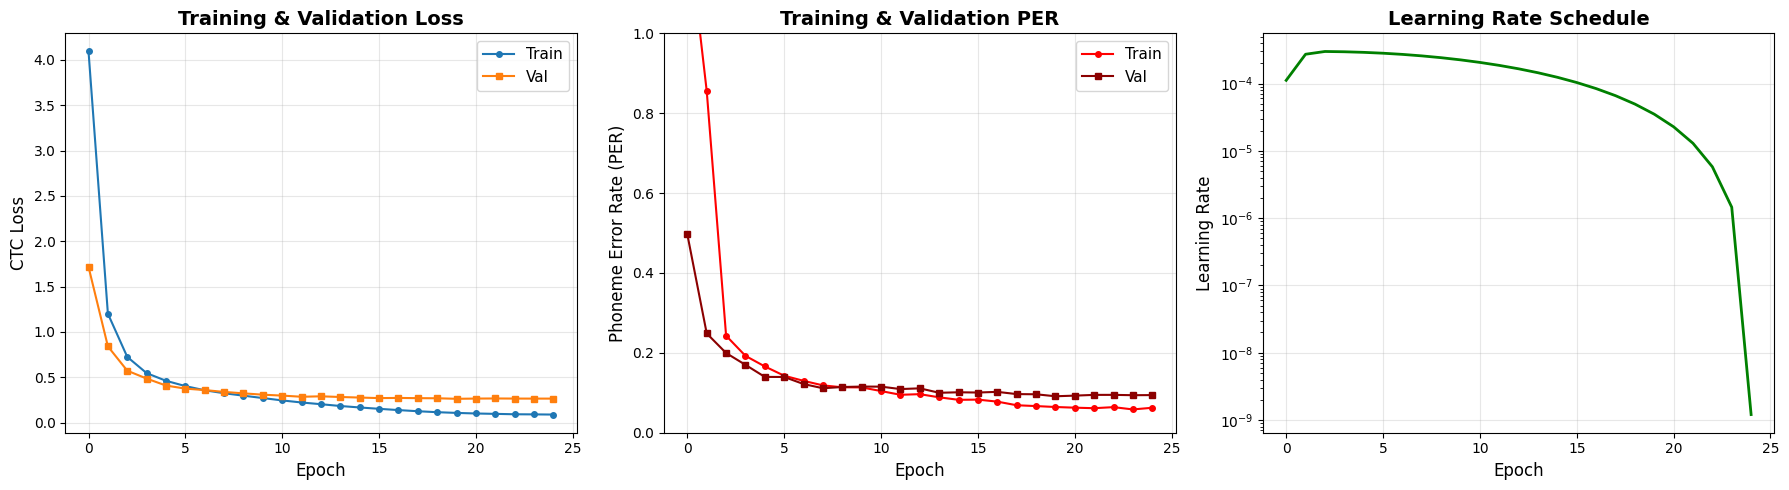


FINAL EVALUATION
Final PER: 0.0942 (9.42%)
Phoneme Accuracy: 0.9058 (90.58%)
Best Val Loss: 0.2635
Final Train Loss: 0.0897
Final Val Loss: 0.2656
Total Epochs Trained: 25

SAMPLE PREDICTIONS

Sample 1:
  TRUE: ㄱ ㅕ ㄹ ㄱ ㅘ ㅇ ㅔ <sp> ㄴ ㅓ ㅁ ㅜ <sp> ㅅ ㅣ ㄴ ㄱ ㅕ ㅇ <sp> ㅆ ㅡ ㅈ ㅣ <sp> ㅁ ㅏ ㄹ ㅏ .
  PRED: ㄱ ㅕ ㄹ ㄱ ㅘ ㅇ ㅔ <sp> ㄴ ㅓ ㅁ ㅜ <sp> ㅅ ㅣ ㄴ ㄱ ㅕ ㅇ <sp> ㅆ ㅡ ㅈ ㅣ <sp> ㅁ ㅏ ㄹ ㅏ .
  PER: 0.033

Sample 2:
  TRUE: ㅂ ㅣ ㅎ ㅐ ㅇ ㄱ ㅣ ㄱ ㅏ <sp> ㅁ ㅏ ㄶ ㅇ ㅣ <sp> ㅎ ㅡ ㄴ ㄷ ㅡ ㄹ ㄹ ㅕ ㅅ ㅓ <sp> ㅁ ㅜ ㅅ
  PRED: ㅂ ㅣ ㅎ ㅐ ㅇ ㄱ ㅣ ㄱ ㅏ <sp> ㅁ ㅏ ㄶ ㅇ ㅣ <sp> ㅎ ㅜ ㄴ <sp> ㄷ ㅡ ㄹ ㄹ ㅕ ㅅ ㅓ <sp> ㅁ ㅜ
  PER: 0.051

Sample 3:
  TRUE: ㅈ ㅣ ㅂ ㅈ ㅜ ㅇ ㅁ ㅏ ㄴ <sp> ㅎ ㅏ ㅁ ㅕ ㄴ <sp> ㄱ ㅡ <sp> ㅇ ㅣ ㄹ ㅇ ㅡ ㄴ <sp> ㄱ ㅡ ㄹ ㅓ
  PRED: ㅈ ㅣ ㅂ ㅈ ㅜ ㄱ ㅁ ㅏ ㄴ <sp> ㅎ ㅏ ㅁ ㅕ ㄴ <sp> ㄱ ㅡ <sp> ㅇ ㅣ ㄹ ㅇ ㅡ ㄴ <sp> ㄱ ㅡ ㄹ ㅓ
  PER: 0.060

Sample 4:
  TRUE: ㄴ ㅐ ㄱ ㅏ <sp> ㅈ ㅏ ㄱ ㅣ ㅎ ㅏ ㄴ ㅌ ㅔ <sp> ㄱ ㅓ ㅈ ㅣ ㅅ ㅁ ㅏ ㄹ ㅎ ㅏ ㄴ <sp> ㄱ ㅓ ㄹ
  PRED: ㄴ ㅐ ㄱ ㅏ <sp> ㅈ ㅏ ㄱ ㅐ ㅎ ㅏ ㄴ ㅌ ㅔ <sp> ㄱ ㅓ ㅈ ㅣ ㅅ ㅁ ㅏ ㄹ ㅎ ㅏ ㄴ <sp> ㄱ ㅓ ㄹ
  PER: 0.082

Sample 5:
  TRUE: ㅇ ㅓ ㄷ ㅣ ㅇ ㅔ ㅅ ㅓ <sp> ㅇ ㅕ ㅇ ㅇ ㅓ ㄹ ㅡ ㄹ <sp> ㅂ ㅐ ㅇ ㅜ ㅅ ㅕ ㅆ ㅇ ㅓ ㅇ

In [12]:
# ============================================================================
# ============================================================================
# THAY THẾ CELL 6 - TRAINING SCRIPT (FIXED VERSION)
# ============================================================================
# ============================================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import gc

print("\n" + "="*70)
print("PREPARING DATASET")
print("="*70)

# --- Pre-load Wav2Vec2 model in main process (FIX CUDA multiprocessing) ---
print("Pre-loading Wav2Vec2 model...")
get_wav2vec2_model()
print("✅ Wav2Vec2 model pre-loaded")

# --- OPTIMIZATION: Pre-extract features to speed up training ---
# This extracts features once before training instead of every epoch
# Training will be MUCH faster after this step
feature_cache = {}
if 'pre_extract_features' in globals():
    print("\n" + "="*70)
    print("OPTIMIZATION: Pre-extracting Wav2Vec2 features")
    print("="*70)
    print("This will take some time but will make training 10-20x faster!")
    feature_cache = pre_extract_features(valid_pairs, batch_size=32)
    print(f"✅ Cached features for {len(feature_cache)} samples")
else:
    print("\n⚠️  WARNING: pre_extract_features function not found!")
    print("Please run Cell 2 first to load the function, or features will be extracted on-the-fly (slower).")
    print("Creating dataset without pre-extracted features...")

# --- Create Dataset with cached features (or empty cache if not pre-extracted) ---
dataset = CTCDataset(valid_pairs, p2id, mean_std=(mean, std), feature_cache=feature_cache)

# 90-10 split (nhiều data training hơn)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f"Train samples: {train_size:,}")
print(f"Val samples: {val_size:,}")

# --- DataLoaders (FIX: num_workers=0 to avoid CUDA multiprocessing error) ---
train_loader = DataLoader(
    train_dataset,
    batch_size=24,  # Tăng batch size
    shuffle=True,
    collate_fn=ctc_collate_fn,
    num_workers=0,  # FIX: Must be 0 when using CUDA models in dataset
    pin_memory=True if device.type == 'cuda' else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=24,
    shuffle=False,
    collate_fn=ctc_collate_fn,
    num_workers=0,  # FIX: Must be 0 when using CUDA models in dataset
    pin_memory=True if device.type == 'cuda' else False
)

# --- Create SMALLER Model ---
model = ConformerPronunciationModel(
    input_dim=768,  # Wav2Vec2 feature dimension
    num_phonemes=len(p2id),
    dim=256,        # Giảm từ 384
    heads=4,        # Giảm từ 6
    depth=3,        # Giảm từ 4
    dropout=0.2     # Giảm từ 0.3
).to(device)

print(f"\n{'='*70}")
print(f"MODEL ARCHITECTURE (OPTIMIZED)")
print(f"{'='*70}")
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Hidden Dim: 256 (reduced from 384)")
print(f"Depth: 3 (reduced from 4)")
print(f"Heads: 4 (reduced from 6)")
print(f"Dropout: 0.2")
print(f"Batch Size: 24")
print(f"{'='*70}\n")

# --- TRAIN ---
print("🚀 Starting training with FIXED PER calculation...\n")

hist = train_ctc(
    model, 
    train_loader, 
    val_loader, 
    device, 
    epochs=25,      # Tăng epochs
    lr=1e-4         # GIẢM LR từ 5e-4 → 1e-4
)

# --- Plot Results ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Loss
axes[0].plot(hist["train_loss"], 'o-', label='Train', markersize=4)
axes[0].plot(hist["val_loss"], 's-', label='Val', markersize=4)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('CTC Loss', fontsize=12)
axes[0].set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)

# Plot 2: PER
axes[1].plot(hist["train_per"], 'o-', label='Train', markersize=4, color='red')
axes[1].plot(hist["val_per"], 's-', label='Val', markersize=4, color='darkred')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Phoneme Error Rate (PER)', fontsize=12)
axes[1].set_title('Training & Validation PER', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3)
axes[1].set_ylim([0, 1])

# Plot 3: Learning Rate
axes[2].plot(hist["lr"], '-', linewidth=2, color='green')
axes[2].set_xlabel('Epoch', fontsize=12)
axes[2].set_ylabel('Learning Rate', fontsize=12)
axes[2].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
axes[2].grid(alpha=0.3)
axes[2].set_yscale('log')

plt.tight_layout()
plt.savefig(REPORT_DIR / "training_fixed.png", dpi=150, bbox_inches='tight')
plt.show()

# --- Final Evaluation ---
print(f"\n{'='*70}")
print(f"FINAL EVALUATION")
print(f"{'='*70}")

per = evaluate_per(model, val_loader, device, id2p)

print(f"Final PER: {per:.4f} ({per*100:.2f}%)")
print(f"Phoneme Accuracy: {(1-per):.4f} ({(1-per)*100:.2f}%)")
print(f"Best Val Loss: {min(hist['val_loss']):.4f}")
print(f"Final Train Loss: {hist['train_loss'][-1]:.4f}")
print(f"Final Val Loss: {hist['val_loss'][-1]:.4f}")
print(f"Total Epochs Trained: {len(hist['train_loss'])}")
print(f"{'='*70}")

# --- Sample Predictions ---
print(f"\n{'='*70}")
print(f"SAMPLE PREDICTIONS")
print(f"{'='*70}")

model.eval()
with torch.no_grad():
    for i, (x, x_len, y, y_len) in enumerate(val_loader):
        if i >= 1:
            break
        
        x = x.to(device)
        log_probs = F.log_softmax(model(x), dim=-1)
        preds = ctc_greedy_decode(log_probs.cpu())
        trues = y.cpu().numpy()
        
        for j in range(min(5, len(preds))):
            pred_phonemes = [id2p.get(p, '?') for p in preds[j][:30]]
            true_phonemes = [id2p.get(t, '?') for t in trues[j][:y_len[j]] if t != 0][:30]
            
            print(f"\nSample {j+1}:")
            print(f"  TRUE: {' '.join(true_phonemes)}")
            print(f"  PRED: {' '.join(pred_phonemes)}")
            
            sample_err = levenshtein_distance(preds[j], [t for t in trues[j][:y_len[j]] if t != 0])
            sample_per = sample_err / max(y_len[j], 1)
            print(f"  PER: {sample_per:.3f}")

print(f"\n{'='*70}")
print(f"✅ Training completed! Model saved to: {MODEL_PATH}")
print(f"{'='*70}\n")

# Clear memory
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

In [ ]:
# ============================================================================
# HYPERPARAMETER OPTIMIZATION VỚI HYPERBANDPRUNER
# ============================================================================

%pip install optuna -q

import optuna
from optuna.pruners import HyperbandPruner
from optuna.visualization import (
    plot_optimization_history,
    plot_param_importances,
    plot_parallel_coordinate,
    plot_contour
)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("✅ Optuna installed!")

# ============================================================================
# OBJECTIVE FUNCTION CHO OPTUNA STUDY - SỬ DỤNG train_ctc ĐÃ TÍCH HỢP
# ============================================================================

def objective(trial):
    """
    Objective function cho Optuna study
    Sử dụng train_ctc đã tích hợp với HyperbandPruner
    """
    # Suggest hyperparameters
    dim = trial.suggest_int('dim', 128, 384, step=64)
    heads = trial.suggest_int('heads', 2, 8, step=2)
    depth = trial.suggest_int('depth', 2, 5)
    dropout = trial.suggest_float('dropout', 0.1, 0.4, step=0.1)
    lr = trial.suggest_float('lr', 1e-5, 5e-4, log=True)
    
    # Create model với hyperparameters
    model = ConformerPronunciationModel(
        input_dim=768,
        num_phonemes=len(p2id),
        dim=dim,
        heads=heads,
        depth=depth,
        dropout=dropout
    ).to(device)
    
    # Sử dụng train_ctc đã tích hợp với trial parameter
    # train_ctc sẽ tự động report và prune khi cần
    best_val_per = train_ctc(
        model,
        train_loader,
        val_loader,
        device,
        epochs=10,  # Giảm epochs để tăng tốc hyperparameter search
        lr=lr,
        trial=trial  # ✅ Truyền trial để enable HyperbandPruner
    )
    
    return best_val_per

# ============================================================================
# CHẠY HYPERPARAMETER OPTIMIZATION
# ============================================================================

print("\n" + "="*70)
print("HYPERPARAMETER OPTIMIZATION VỚI HYPERBANDPRUNER")
print("="*70)

# Tạo HyperbandPruner
pruner = HyperbandPruner(
    min_resource=1,
    max_resource=10,  # epochs
    reduction_factor=3
)

# Tạo study
study = optuna.create_study(
    direction='minimize',  # Minimize PER
    pruner=pruner,
    study_name='pronunciation_hyperopt'
)

print(f"\nHyperparameter Search Space:")
print(f"  - dim: [128, 192, 256, 320, 384]")
print(f"  - heads: [2, 4, 6, 8]")
print(f"  - depth: [2, 3, 4, 5]")
print(f"  - dropout: [0.1, 0.2, 0.3, 0.4]")
print(f"  - lr: [1e-5, 5e-4] (log scale)")
print(f"\nPruner: HyperbandPruner (min_resource=1, max_resource=10, reduction_factor=3)")
print(f"  → Tích hợp vào train_ctc chính (không tách riêng)")
print(f"Trials: 20 (có thể tăng nếu cần)")
print("="*70 + "\n")

# Chạy optimization
study.optimize(objective, n_trials=20, show_progress_bar=True)

# ============================================================================
# IN KẾT QUẢ
# ============================================================================

print("\n" + "="*70)
print("KẾT QUẢ HYPERPARAMETER OPTIMIZATION")
print("="*70)

print(f"\n📊 Tổng số trials: {len(study.trials)}")
print(f"✅ Completed: {len([t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE])}")
print(f"✂️  Pruned: {len([t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED])}")
print(f"❌ Failed: {len([t for t in study.trials if t.state == optuna.trial.TrialState.FAIL])}")

best_trial = study.best_trial
print(f"\n🏆 BEST TRIAL:")
print(f"  Trial #{best_trial.number}")
print(f"  Best Val PER: {best_trial.value:.4f} ({best_trial.value*100:.2f}%)")
print(f"\n  Best Hyperparameters:")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

# ============================================================================
# TẠO BẢN ĐỒ VÀ VISUALIZATION
# ============================================================================

print("\n" + "="*70)
print("TẠO BẢN ĐỒ VÀ VISUALIZATION")
print("="*70)

# 1. Optimization History
fig1 = plot_optimization_history(study)
fig1.update_layout(
    title="Optimization History - HyperbandPruner",
    width=900,
    height=500
)
try:
    fig1.write_image(str(REPORT_DIR / "hyperopt_history.png"))
    print("✅ Saved: hyperopt_history.png")
except:
    print("⚠️  Could not save image (install kaleido: pip install kaleido)")
    fig1.show()

# 2. Parameter Importances
fig2 = plot_param_importances(study)
fig2.update_layout(
    title="Parameter Importances",
    width=900,
    height=500
)
try:
    fig2.write_image(str(REPORT_DIR / "hyperopt_importances.png"))
    print("✅ Saved: hyperopt_importances.png")
except:
    print("⚠️  Could not save image (install kaleido: pip install kaleido)")
    fig2.show()

# 3. Parallel Coordinate Plot
fig3 = plot_parallel_coordinate(study)
fig3.update_layout(
    title="Parallel Coordinate Plot - Hyperparameter Relationships",
    width=1200,
    height=600
)
try:
    fig3.write_image(str(REPORT_DIR / "hyperopt_parallel.png"))
    print("✅ Saved: hyperopt_parallel.png")
except:
    print("⚠️  Could not save image (install kaleido: pip install kaleido)")
    fig3.show()

# 4. Contour Plot (cho 2 parameters quan trọng nhất)
try:
    fig4 = plot_contour(study, params=['dim', 'lr'])
    fig4.update_layout(
        title="Contour Plot: dim vs lr",
        width=800,
        height=600
    )
    try:
        fig4.write_image(str(REPORT_DIR / "hyperopt_contour.png"))
        print("✅ Saved: hyperopt_contour.png")
    except:
        print("⚠️  Could not save image (install kaleido: pip install kaleido)")
        fig4.show()
except Exception as e:
    print(f"⚠️  Could not create contour plot: {e}")

# 5. Custom Heatmap của hyperparameter space
print("\n📊 Tạo Heatmap của Hyperparameter Space...")

# Lấy tất cả trials
trials_df = study.trials_dataframe()
trials_df = trials_df[trials_df['state'] == 'COMPLETE']

# Tạo heatmap cho các hyperparameters quan trọng
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Heatmap 1: dim vs heads
if 'params_dim' in trials_df.columns and 'params_heads' in trials_df.columns:
    pivot1 = trials_df.pivot_table(
        values='value',
        index='params_dim',
        columns='params_heads',
        aggfunc='mean'
    )
    sns.heatmap(pivot1, annot=True, fmt='.4f', cmap='RdYlGn_r', ax=axes[0,0], cbar_kws={'label': 'Val PER'})
    axes[0,0].set_title('Heatmap: dim vs heads (Val PER)', fontsize=12, fontweight='bold')
    axes[0,0].set_xlabel('Heads', fontsize=10)
    axes[0,0].set_ylabel('Dim', fontsize=10)

# Heatmap 2: depth vs dropout
if 'params_depth' in trials_df.columns and 'params_dropout' in trials_df.columns:
    pivot2 = trials_df.pivot_table(
        values='value',
        index='params_depth',
        columns='params_dropout',
        aggfunc='mean'
    )
    sns.heatmap(pivot2, annot=True, fmt='.4f', cmap='RdYlGn_r', ax=axes[0,1], cbar_kws={'label': 'Val PER'})
    axes[0,1].set_title('Heatmap: depth vs dropout (Val PER)', fontsize=12, fontweight='bold')
    axes[0,1].set_xlabel('Dropout', fontsize=10)
    axes[0,1].set_ylabel('Depth', fontsize=10)

# Scatter 3: lr vs PER
if 'params_lr' in trials_df.columns:
    axes[1,0].scatter(trials_df['params_lr'], trials_df['value'], alpha=0.6, s=100, c=trials_df['value'], cmap='RdYlGn_r')
    axes[1,0].set_xlabel('Learning Rate', fontsize=10)
    axes[1,0].set_ylabel('Val PER', fontsize=10)
    axes[1,0].set_title('Learning Rate vs Val PER', fontsize=12, fontweight='bold')
    axes[1,0].set_xscale('log')
    axes[1,0].grid(alpha=0.3)

# Scatter 4: dim vs PER
if 'params_dim' in trials_df.columns:
    axes[1,1].scatter(trials_df['params_dim'], trials_df['value'], alpha=0.6, s=100, c=trials_df['value'], cmap='RdYlGn_r')
    axes[1,1].set_xlabel('Hidden Dimension', fontsize=10)
    axes[1,1].set_ylabel('Val PER', fontsize=10)
    axes[1,1].set_title('Hidden Dimension vs Val PER', fontsize=12, fontweight='bold')
    axes[1,1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(REPORT_DIR / "hyperopt_heatmap.png", dpi=150, bbox_inches='tight')
print("✅ Saved: hyperopt_heatmap.png")
plt.show()

# 6. In bảng kết quả chi tiết
print("\n" + "="*70)
print("BẢNG KẾT QUẢ CHI TIẾT (Top 10 Trials)")
print("="*70)

# Sắp xếp theo PER
top_trials = sorted(
    [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE],
    key=lambda x: x.value
)[:10]

print(f"\n{'Trial':<8} {'PER':<12} {'Dim':<8} {'Heads':<8} {'Depth':<8} {'Dropout':<10} {'LR':<12}")
print("-" * 70)

for i, trial in enumerate(top_trials, 1):
    params = trial.params
    print(f"{trial.number:<8} {trial.value:<12.4f} {params.get('dim', 'N/A'):<8} "
          f"{params.get('heads', 'N/A'):<8} {params.get('depth', 'N/A'):<8} "
          f"{params.get('dropout', 'N/A'):<10.2f} {params.get('lr', 'N/A'):<12.2e}")

print("\n" + "="*70)
print("✅ Hyperparameter Optimization hoàn tất!")
print(f"📁 Tất cả visualizations đã lưu vào: {REPORT_DIR}")
print("="*70)


In [13]:
# ============================================================================
# PRONUNCIATION CHECKER - Word-level & Character-level Feedback
# ============================================================================
"""
Module để check pronunciation tương tự như hình ảnh:
- Word-level checking (đánh dấu từ đúng/sai)
- Character-level marking (một phần từ có thể sai)
- Visual feedback với màu sắc
- IPA transcription
- Score/percentage
"""

from dataclasses import dataclass
from typing import List, Tuple, Dict
import numpy as np

@dataclass
class WordFeedback:
    """Thông tin phản hồi cho một từ"""
    word: str
    word_start: int  # Vị trí bắt đầu trong câu
    word_end: int    # Vị trí kết thúc trong câu
    is_correct: bool  # Toàn bộ từ đúng không
    accuracy: float  # Độ chính xác (0-1)
    char_feedback: List[bool]  # Từng ký tự/phoneme đúng/sai
    expected_phonemes: List[str]
    predicted_phonemes: List[str]

@dataclass
class PronunciationResult:
    """Kết quả check pronunciation cho toàn bộ câu"""
    text: str
    ipa_transcription: str
    overall_score: float  # 0-100
    words: List[WordFeedback]
    predicted_phonemes: List[str]
    expected_phonemes: List[str]

def levenshtein_distance_with_alignment(seq1: List, seq2: List) -> Tuple[int, List[int]]:
    """
    Tính Levenshtein distance và trả về alignment
    Returns: (distance, alignment_info)
    alignment_info: list of (seq1_idx, seq2_idx, match/sub/ins/del)
    """
    n, m = len(seq1), len(seq2)
    dp = [[0] * (m + 1) for _ in range(n + 1)]
    path = [[None] * (m + 1) for _ in range(n + 1)]
    
    # Initialize
    for i in range(n + 1):
        dp[i][0] = i
        if i > 0:
            path[i][0] = (i-1, 0, 'del')
    for j in range(m + 1):
        dp[0][j] = j
        if j > 0:
            path[0][j] = (0, j-1, 'ins')
    
    # Fill DP table
    for i in range(1, n + 1):
        for j in range(1, m + 1):
            if seq1[i-1] == seq2[j-1]:
                dp[i][j] = dp[i-1][j-1]
                path[i][j] = (i-1, j-1, 'match')
            else:
                del_cost = dp[i-1][j] + 1
                ins_cost = dp[i][j-1] + 1
                sub_cost = dp[i-1][j-1] + 1
                
                if del_cost <= ins_cost and del_cost <= sub_cost:
                    dp[i][j] = del_cost
                    path[i][j] = (i-1, j, 'del')
                elif ins_cost <= sub_cost:
                    dp[i][j] = ins_cost
                    path[i][j] = (0, j-1, 'ins')
                else:
                    dp[i][j] = sub_cost
                    path[i][j] = (i-1, j-1, 'sub')
    
    # Backtrack to get alignment
    alignment = []
    i, j = n, m
    while i > 0 or j > 0:
        if path[i][j]:
            pi, pj, op = path[i][j]
            alignment.append((i-1 if i > 0 else -1, j-1 if j > 0 else -1, op))
            i, j = pi, pj
        else:
            break
    
    alignment.reverse()
    return dp[n][m], alignment

def map_phonemes_to_words(text: str, phonemes: List[str]) -> Dict[str, List[str]]:
    """
    Map phonemes về words dựa trên text
    Returns: dict mapping word -> list of phonemes
    """
    # Split text into words
    words = text.split()
    word_phonemes = {word: [] for word in words}
    
    # Simple heuristic: distribute phonemes evenly
    # In practice, you'd use forced alignment (e.g., Montreal Forced Aligner)
    phn_per_word = len(phonemes) / len(words) if words else []
    
    phn_idx = 0
    for word in words:
        # Calculate how many phonemes for this word
        word_phn_count = int(phn_per_word) if isinstance(phn_per_word, float) else len(phonemes) // len(words)
        if phn_idx + word_phn_count > len(phonemes):
            word_phn_count = len(phonemes) - phn_idx
        
        word_phonemes[word] = phonemes[phn_idx:phn_idx + word_phoneme_count]
        phn_idx += word_phn_count
    
    return word_phonemes

def check_pronunciation(
    audio_path: str,
    text: str,
    model,
    id2p: Dict[int, str],
    device,
    extract_features_fn
) -> PronunciationResult:
    """
    Check pronunciation của một audio file với text expected
    
    Args:
        audio_path: Path to audio file
        text: Expected text in Hangul
        model: Trained pronunciation model
        id2p: ID to phoneme mapping
        device: PyTorch device
        extract_features_fn: Function to extract Wav2Vec2 features
    
    Returns:
        PronunciationResult với word-level và character-level feedback
    """
    # 1. Extract features
    audio, sr = sf.read(audio_path)
    audio = librosa.resample(audio, orig_sr=sr, target_sr=SAMPLE_RATE)
    features = extract_features_fn(audio, SAMPLE_RATE)
    features = torch.tensor(features, dtype=torch.float32).unsqueeze(0).to(device)
    
    # 2. Predict phonemes
    model.eval()
    with torch.no_grad():
        logits = model(features)
        log_probs = F.log_softmax(logits, dim=-1)
        pred_phonemes = ctc_greedy_decode(log_probs.cpu())
        pred_phonemes = [id2p.get(p, '?') for p in pred_phonemes[0]]
    
    # 3. Get expected phonemes from text
    expected_phonemes = hangul_g2p(text)
    expected_phonemes = [p for p in expected_phonemes if p != '<sp>']
    
    # 4. Calculate overall score
    edit_dist, alignment = levenshtein_distance_with_alignment(pred_phonemes, expected_phonemes)
    overall_score = max(0, 100 * (1 - edit_dist / max(len(expected_phonemes), 1)))
    
    # 5. Word-level checking
    words = text.split()
    word_feedbacks = []
    
    # Map phonemes to words (simplified - would need proper alignment in production)
    word_phn_map = map_phonemes_to_words(text, expected_phonemes)
    pred_word_phn_map = map_phonemes_to_words(text, pred_phonemes)
    
    word_start = 0
    for word in words:
        word_end = word_start + len(word)
        exp_phns = word_phn_map.get(word, [])
        pred_phns = pred_word_phn_map.get(word, [])
        
        # Check word-level accuracy
        word_edit_dist, word_alignment = levenshtein_distance_with_alignment(pred_phns, exp_phns)
        word_acc = max(0, 1 - word_edit_dist / max(len(exp_phns), 1))
        is_correct = word_acc >= 0.8  # Threshold
        
        # Character-level feedback (simplified - map to Hangul characters)
        char_feedback = []
        # For each character in word, check if corresponding phonemes match
        for char in word:
            # Simplified: if word is mostly correct, all chars are correct
            # In practice, need character-to-phoneme alignment
            char_feedback.append(is_correct)
        
        word_feedbacks.append(WordFeedback(
            word=word,
            word_start=word_start,
            word_end=word_end,
            is_correct=is_correct,
            accuracy=word_acc,
            char_feedback=char_feedback,
            expected_phonemes=exp_phns,
            predicted_phonemes=pred_phns
        ))
        
        word_start = word_end + 1  # +1 for space
    
    # 6. Generate IPA transcription
    ipa_transcription = " ".join([KOREAN_TO_IPA.get(p, p) for p in expected_phonemes])
    
    return PronunciationResult(
        text=text,
        ipa_transcription=ipa_transcription,
        overall_score=overall_score,
        words=word_feedbacks,
        predicted_phonemes=pred_phonemes,
        expected_phonemes=expected_phonemes
    )

def visualize_pronunciation_feedback(result: PronunciationResult, save_path=None):
    """
    Visualize pronunciation feedback tương tự như hình ảnh
    - Xanh lá = đúng
    - Đỏ = sai
    """
    import matplotlib.pyplot as plt
    from matplotlib.patches import Rectangle
    
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.axis('off')
    
    y_pos = 0.8
    
    # Draw text with color coding
    text_x = 0.1
    text_y = y_pos
    
    for word_fb in result.words:
        # Determine color
        color = 'green' if word_fb.is_correct else 'red'
        
        # Draw word
        ax.text(text_x, text_y, word_fb.word, 
                fontsize=14, color=color, weight='bold',
                bbox=dict(boxstyle='round', facecolor='white', edgecolor=color, linewidth=2))
        
        # Move x position
        text_x += len(word_fb.word) * 0.015 + 0.02  # Approximate width + space
    
    # Draw IPA transcription below
    ipa_y = y_pos - 0.15
    ax.text(0.1, ipa_y, f"IPA: {result.ipa_transcription}",
            fontsize=11, style='italic', color='gray')
    
    # Draw score
    score_color = 'green' if result.overall_score >= 80 else 'orange' if result.overall_score >= 60 else 'red'
    ax.text(0.85, 0.9, f"{result.overall_score:.0f}%",
            fontsize=24, weight='bold', color=score_color,
            ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='lightgray', edgecolor=score_color, linewidth=2))
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

print("✅ Pronunciation Checker module loaded!")
print("   - Word-level checking")
print("   - Character-level marking")
print("   - Visual feedback with colors")
print("   - IPA transcription")


✅ Pronunciation Checker module loaded!
   - Word-level checking
   - Character-level marking
   - Visual feedback with colors
   - IPA transcription


In [15]:
# CELL KIỂM TRA - Chạy để debug
import json

print("="*70)
print("KIỂM TRA P2ID DICTIONARY")
print("="*70)

# Load p2id
p2id_path = PROJECT_ROOT / "dictionary" / "p2id.json"
p2id = json.loads(p2id_path.read_text(encoding="utf-8"))

print(f"\nTổng số phonemes: {len(p2id)}")
print(f"\n10 phonemes đầu tiên:")
for i, (k, v) in enumerate(list(p2id.items())[:10]):
    print(f"  '{k}': {v}")

print(f"\n10 phonemes cuối:")
for k, v in list(p2id.items())[-10:]:
    print(f"  '{k}': {v}")

# Kiểm tra blank token
if '<blank>' in p2id:
    print(f"\n✅ Có <blank> token: ID = {p2id['<blank>']}")
else:
    print(f"\n❌ KHÔNG CÓ <blank> token!")
    print(f"   → Phoneme đầu tiên có ID=0, CONFLICT với CTC blank!")

# Kiểm tra một file .phn
sample_phn = list(PHN_DIR.glob("**/*.phn"))[0]
phonemes = sample_phn.read_text(encoding="utf-8").split()
print(f"\nSample phonemes từ file: {sample_phn.name}")
print(f"  {' '.join(phonemes[:20])}")

# Map sang IDs
ids = [p2id.get(p, -1) for p in phonemes[:20]]
print(f"\nIDs tương ứng:")
print(f"  {ids}")

# Kiểm tra có ID=-1 không (phoneme không có trong dict)
missing = [p for p in phonemes if p not in p2id]
if missing:
    print(f"\n❌ CÓ {len(missing)} PHONEMES KHÔNG CÓ TRONG DICTIONARY:")
    print(f"   {missing[:10]}")
else:
    print(f"\n✅ Tất cả phonemes đều có trong dictionary")

print("="*70)

KIỂM TRA P2ID DICTIONARY

Tổng số phonemes: 55

10 phonemes đầu tiên:
  '<blank>': 0
  '!': 1
  ',': 2
  '.': 3
  '<sp>': 4
  '?': 5
  'ㄱ': 6
  'ㄲ': 7
  'ㄳ': 8
  'ㄴ': 9

10 phonemes cuối:
  'ㅚ': 45
  'ㅛ': 46
  'ㅜ': 47
  'ㅝ': 48
  'ㅞ': 49
  'ㅟ': 50
  'ㅠ': 51
  'ㅡ': 52
  'ㅢ': 53
  'ㅣ': 54

✅ Có <blank> token: ID = 0

Sample phonemes từ file: 2_0918.phn
  ㅈ ㅣ ㄱ ㅡ ㅁ <sp> ㅈ ㅔ <sp> ㅅ ㅏ ㅇ ㅎ ㅘ ㅇ ㅇ ㅣ <sp> ㅈ ㅓ

IDs tương ứng:
  [27, 54, 6, 52, 20, 4, 27, 39, 4, 24, 34, 26, 33, 43, 26, 26, 54, 4, 27, 38]

✅ Tất cả phonemes đều có trong dictionary
